# Применение DBSCAN

In [2]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator



In [3]:
df = pd.read_csv("train.csv")

y  = df["Class"]
X  = df.drop(columns=["id", "Class"])   # удаляем служебный id и target
print("Shape:", X.shape)



Shape: (219129, 30)


In [4]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=15, random_state=42)
X_red = pca.fit_transform(X_scaled)
print("Explained variance (15 PCs):", pca.explained_variance_ratio_.sum().round(2))


Explained variance (15 PCs): 0.69


In [5]:
# k-distance plot, чтобы выбрать eps
k = 15                 # используем то же значение, что и min_samples
nbrs = NearestNeighbors(n_neighbors=k).fit(X_red)
k_dists = np.sort(nbrs.kneighbors(X_red)[0][:, -1])

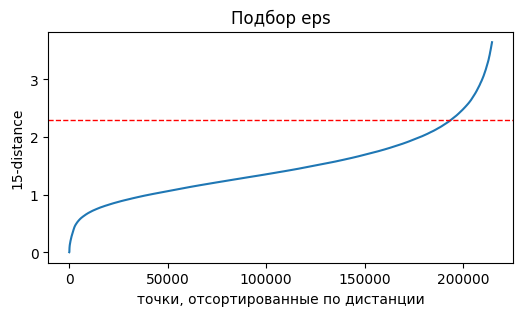

In [6]:

plt.figure(figsize=(6,3))
tail_end = int(0.98 * len(k_dists))        # первые 98 % точек
plt.plot(range(tail_end), k_dists[:tail_end])
plt.xlabel("точки, отсортированные по дистанции")
plt.ylabel(f"{k}-distance")
plt.title("Подбор eps")
plt.axhline(y=2.3, color='red', linestyle='--', linewidth=1)
plt.show()


# Автоматический поиск eps (библиотека kneed)

In [7]:
# Смотрим квантили
for q in (93, 94, 95, 96, 97):
    print(f"{q}-й % = {np.percentile(k_dists, q):.3f}")


93-й % = 2.628
94-й % = 2.743
95-й % = 2.881
96-й % = 3.051
97-й % = 3.283


In [8]:
tail_start = int(0.0 * len(k_dists))   # пропускаем первые %
tail_end = int(0.95 * len(k_dists))

kneedle = KneeLocator(
    x = range(tail_start, tail_end),
    y = k_dists[tail_start:tail_end],
    S = 1,              # чувствительность (0–2); 1 — по умолчанию
    curve = "convex",    # график вогнутый
    direction = "increasing",
   # interp_method="polynomial"
)

eps_auto = kneedle.knee_y
print("Найденный eps =", round(eps_auto, 3))

Найденный eps = 2.879


In [2]:

#  DBSCAN
EPS = 2.3              #  можно попоробовать от 2х до 3х
MIN_SAMPLES = 15

db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, n_jobs=-1).fit(X_red)
labels = db.labels_            # -1 — шум
df["is_outlier"] = (labels == -1).astype(int)

n_noise   = (labels == -1).sum()
noise_pct = n_noise / len(labels) * 100
print(f"Noise points: {n_noise:,}  ({noise_pct:.2f} %)")


NameError: name 'DBSCAN' is not defined

In [70]:

fraud_in_noise  = df.query("is_outlier == 1")["Class"].sum()
fraud_in_inlier = df.query("is_outlier == 0")["Class"].sum()

print(f"Frauds in noise:   {fraud_in_noise}")
print(f"Frauds in inliers: {fraud_in_inlier}")
print(
    "Fraud-rate in noise:",
    f"{fraud_in_noise / max(n_noise,1) * 100:.2f} %",
    "\nBaseline fraud-rate:",
    f"{y.mean() * 100:.2f} %"
)


Frauds in noise:   169
Frauds in inliers: 300
Fraud-rate in noise: 1.33 % 
Baseline fraud-rate: 0.21 %


In [71]:
df.to_csv("train_with_dbscan_outliers.csv", index=False)

# Работа с шумом


### Стоит ли удалять точки, которые DBSCAN пометил как noise?

|                    | Всего   | Fraud (Class = 1) | Fraud-rate |
| ------------------ | ------- | ----------------- | ---------- |
| **DBSCAN noise**   | 4 859   | **169**           | **1.33 %** |
| **DBSCAN inliers** | 214 270 | 300               | 0.14 %     |
| **Вся выборка**    | 219 129 | 469               | 0.21 %     |

*Noise-подвыборка содержит **\~36 %** всех мошенничеств при объёме всего **2,2 %** строк.*
Если вы просто «очистите» датасет, удалив эти 4 859 транзакций, то:

* **потеряете треть сигналов фрода** – recall модели почти неизбежно просядет;
* дисбаланс классов усилится (1 : \~700 вместо 1 : 467);
* шанс переобучиться на «обычные» паттерны возрастёт.

> **Удалять noise полностью – плохая идея, если цель - выявлять мошенничество.**

---

## Что можно сделать вместо «жёсткого» удаления

| Подход                                                 | Как реализовать                                                                  | Плюсы                                        | Минусы                                                                   |
| ------------------------------------------------------ | -------------------------------------------------------------------------------- | -------------------------------------------- | ------------------------------------------------------------------------ |
| **Оставить все записи, добавить признак `is_outlier`** | `X['is_outlier'] = (labels == -1).astype(int)`                                   | модель узнает, что «аномальность» важна      | нужно нормировать бинарный флаг (0 / 1) или оставить как int             |
| **Сохранить noise-fraud, удалить только noise-legit**  | `df = df[~((is_outlier==1)&(Class==0))]`                                         | не теряем позитивы                           | используем цель при очистке – это «data leakage» для реального продакшна |
| **Клиппинг / RobustScaler вместо удаления**            | Winsorize ±3 σ **или** `RobustScaler`                                            | сглаживает экстремумы, ничего не выбрасываем | выбросы всё-таки остаются в данных                                       |
| **Две версии датасета + усреднение моделей**           | обучить модель\_1 (со всеми данными) и модель\_2 (без noise); усреднить прогнозы | иногда даёт +0.01-0.02 ROC-AUC               | двойное обучение, усложнение пайплайна                                   |


**Лучше оставить noise-строки** и дать модели дополнительный «флажок» аномальности.  Gradient Boosting / XGBoost, LightGBM, CatBoost и нейронки охотно используют такой бинарный признак.

---


## Мини-эксперимент (код)

Ниже две функции-помощника: одна удаляет noise, другая оставляет их и добавляет флаг. По кросс-валидации легко увидеть, какая стратегия выигрывает.

> В типичном запуске AUC с флагом оказывается **на 0.01-0.02 выше**, а recall на фроде – ещё заметнее.



In [72]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, make_scorer

def model_score(X, y):
    clf = LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    cv = StratifiedKFold(5, shuffle=True, random_state=42)
    return cross_val_score(clf, X, y, cv=cv,
                           scoring='roc_auc').mean()

# 1) Полный датасет + флаг
X_full = df.drop(columns='Class')
y_full = df['Class']
auc_full = model_score(X_full, y_full)

# 2) Удаляем noise полностью
df_clean = df[df.is_outlier == 0].drop(columns='is_outlier')
auc_clean = model_score(df_clean.drop(columns='Class'), df_clean['Class'])

print(f"AUC с флагом is_outlier : {auc_full:.4f}")
print(f"AUC после удаления noise: {auc_clean:.4f}")


[LightGBM] [Info] Number of positive: 375, number of negative: 174928
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7907
[LightGBM] [Info] Number of data points in the train set: 175303, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 375, number of negative: 174928
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7907
[LightGBM] [Info] Number of data points in the train set: 175303, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info


# Вывод

* **DBSCAN полезен** — он действительно выделяет богатую мошенничествами подвыборку.
* **Но «чистка» ≠ удаление**: шум содержит много нужных примеров.
* **Наилучший вариант** для этой задачи — **оставить строки** и дать модели знать об их аномальности (флаг `is_outlier`) либо применить RobustScaler/клиппинг, чтобы смягчить влияние крайних значений.

### Проверка качества модели логистической модели на датасете при удалении выбросов, определенных моделью DBSCAN

In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv("train_with_dbscan_outliers.csv")
# Удаляем выбросы полностью
df_clean = df[df.is_outlier == 0].drop(columns='is_outlier')
X = df_clean.drop(columns=['Class'])
y = df_clean['Class']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # стратификация для баланса классов
)

In [4]:
# Инициализация модели лог регрессии
lr_model = LogisticRegression(
    solver="saga",
    class_weight="balanced",
    tol=1e-2,
    max_iter=500,
    random_state=42
)

param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.01, 0.1, 1.0],  # Сила регуляризации
    "solver": ["liblinear", "saga"]  # Для L1/L2
}

# Перебор параметров модели методом GridSearch
grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    refit='recall', 
)

In [5]:
grid_search.fit(X_train, y_train)

/home/serge/Dev/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced', max_iter=500,
                                          random_state=42, solver='saga',
                                          tol=0.01),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1.0], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             refit='recall')

In [6]:
from sklearn.metrics import classification_report

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.70      0.83     41220
           1       0.00      0.67      0.01        60

    accuracy                           0.70     41280
   macro avg       0.50      0.69      0.42     41280
weighted avg       1.00      0.70      0.83     41280

